# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [ ]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.layer_1 = DenseLayer(num_features, n_hidden_1)
    self.layer_2 = DenseLayer(n_hidden_1, n_hidden_2)
    self.out_layer = DenseLayer(n_hidden_2, num_classes)


  def __call__(self, x):
    x = self.layer_1(x)
    x = self.layer_2(x)
    x = self.out_layer(x, activation=1)



    return x

In [ ]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:

    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)


    trainable_variables = neural_net.trainable_variables


    gradients = g.gradient(loss, trainable_variables)


    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss

In [ ]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    loss = train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss_value = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss_value)
        accuracy_history.append(acc)
        print(f"Step: {step}, Loss: {loss_value.numpy()}, Accuracy: {acc.numpy()}")


Step: 100, Loss: 275.6876525878906, Accuracy: 0.69921875
Step: 200, Loss: 259.9405212402344, Accuracy: 0.75390625
Step: 300, Loss: 171.93751525878906, Accuracy: 0.78515625
Step: 400, Loss: 162.8167266845703, Accuracy: 0.80078125
Step: 500, Loss: 134.76437377929688, Accuracy: 0.859375
Step: 600, Loss: 186.09243774414062, Accuracy: 0.80859375
Step: 700, Loss: 120.88238525390625, Accuracy: 0.8671875
Step: 800, Loss: 108.15830993652344, Accuracy: 0.875
Step: 900, Loss: 123.51602935791016, Accuracy: 0.875
Step: 1000, Loss: 129.89999389648438, Accuracy: 0.85546875
Step: 1100, Loss: 105.98399353027344, Accuracy: 0.86328125
Step: 1200, Loss: 111.40638732910156, Accuracy: 0.84765625
Step: 1300, Loss: 96.14065551757812, Accuracy: 0.875
Step: 1400, Loss: 80.38282012939453, Accuracy: 0.91015625
Step: 1500, Loss: 94.64595031738281, Accuracy: 0.8671875
Step: 1600, Loss: 102.22660827636719, Accuracy: 0.88671875
Step: 1700, Loss: 98.55953979492188, Accuracy: 0.875
Step: 1800, Loss: 69.30606079101562, 

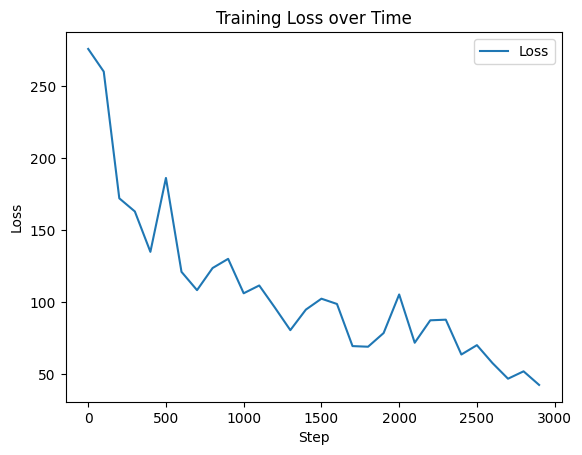

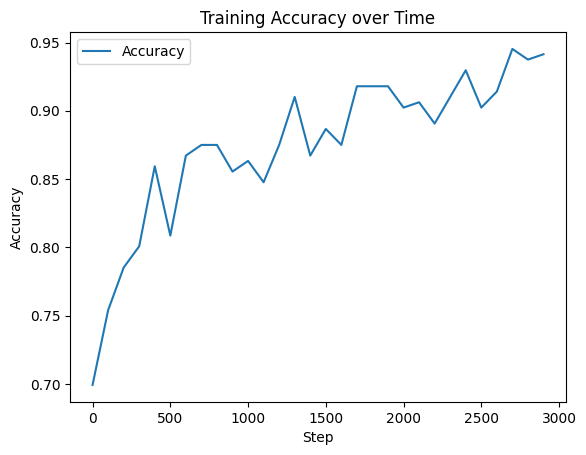

In [ ]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.plot(range(0, training_steps, display_step), loss_history, label="Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss over Time")
plt.legend()
plt.show()

# Виведіть графік точності
plt.plot(range(0, training_steps, display_step), accuracy_history, label="Accuracy")
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.title("Training Accuracy over Time")
plt.legend()
plt.show()



In [ ]:
# Обчисліть точність навченої нейромережі
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
accuracy_on_test = accuracy(neural_net(x_test), y_test)
print(f"Test Accuracy: {accuracy_on_test.numpy()}")
# Тестування моделі на тестових даних
test_loss = cross_entropy(neural_net(x_test), y_test)
print(f"Test Loss: {test_loss.numpy()}")

Test Accuracy: 0.9064000248908997
Test Loss: 3235.061767578125


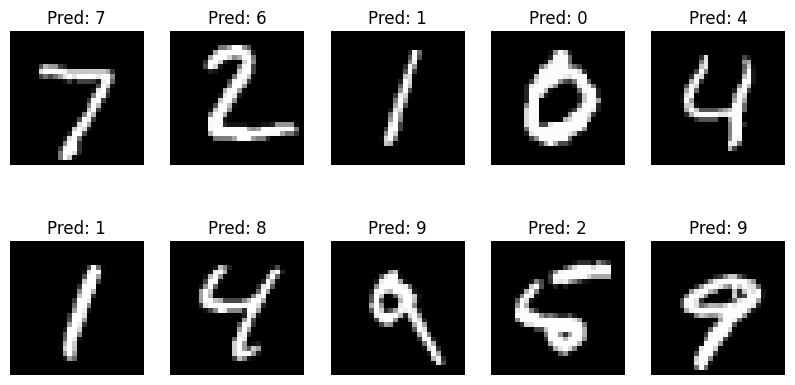

In [ ]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    ax = axes[i//5, i%5]
    img = x_test[i].reshape(28, 28)
    ax.imshow(img, cmap='gray')
    prediction = tf.argmax(neural_net(x_test[i:i+1]), axis=1)
    ax.set_title(f"Pred: {prediction.numpy()[0]}")
    ax.axis('off')
plt.show()


